<a href="https://colab.research.google.com/github/how-to-train-your-model/data-science-portfolio/blob/main/451_Module_9_Coding_Assignment_Computing_order_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Computing order flow


# Libraries

In [35]:
#!pip install sweetviz

In [36]:
# load libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm




In [37]:
# Allows for muliple output in one cell window
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Allows for viewing the complete data in a single window 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [38]:
from google.colab import drive
drive.mount('/content/drive')
!ls -l "/content/drive/My Drive/Colab_Notebooks/MSDS-451/W9"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 84045
-rw------- 1 root root   238374 Mar 19 16:38 '451_Module 9 Coding Assignment: Computing order flow.ipynb'
-rw------- 1 root root 23182018 Mar 18 03:00  ES_1509_FUT_copy.csv
-rw------- 1 root root 23182018 Mar 17 15:12  ES_1509_FUT.csv
-rw------- 1 root root    93442 Mar 17 15:13  ES_continuous_20150828.csv
-rw------- 1 root root 39170891 Mar 17  2019  LCD1.csv
-rw------- 1 root root   193867 Mar 17 15:11 'MSDS451_A9_Pant_Coding Assignment: MDA on economic factors as predictors of S&P 500 index.docx'


Order flow is signed trading volume, where the sign is positive if a trade is executed due to a market buy order and negative if it is due to a market sell order. Order flow is regarded as a significant indicator of whether “informed traders” are buying or selling, as those who have information presumably want immediate executions via market orders. We will use one day of trade ticks of E-mini S&P 500 Futures data for this assignment (downloadable from Canvas as ES_1509_FUT.csv.) Download ES_1509_FUT.csv.)Note the Aggressor flag (B/S) in the last column.

There are two ways to compute order flow from trading data:

The most accurate way uses TAQ data, downloadable from Canvas as ES_1509_FUT.csv Download ES_1509_FUT.csv. Event=T in the second column indicates this is a trade tick, and the Aggressor=B/S  in the last column indicates whether this is buy or sell. This data is courtesy of Algoseek Inc.
 A less accurate way uses only price-and-volume bar data, downloadable from Canvas as ES_continuous_20150828.csv Download ES_continuous_20150828.csv. We will compare the two methods on E-mini S&P 500 (ES) future data. This data is also courtesy of Algoseek Inc.

In [39]:
w9_files = "/content/drive/My Drive/Colab_Notebooks/MSDS-451/W9"

TAQ_DATA = pd.read_csv(w9_files+"/ES_1509_FUT_copy.csv")
PV_BAR_DATA = pd.read_csv(w9_files+"/ES_continuous_20150828.csv")

print(TAQ_DATA.shape)
TAQ_DATA.head()

print(PV_BAR_DATA.shape)
PV_BAR_DATA.head()


(858504, 5)


,Time,Event,Price,Quantity,Aggressor
0,00:00:00.000,B,1988.75,17,NaN
1,00:00:00.000,A,1989.00,33,NaN
2,00:00:00.001,T,1988.75,2,S
3,00:00:00.005,T,1988.75,2,S
4,00:00:00.005,T,1988.75,1,S


(1005, 6)


,Time,Open,High,Low,Close,Volume
0,2015-08-28 00:00:00,1.943063,1.943308,1.943063,1.943063,49
1,2015-08-28 00:01:00,1.943063,1.943308,1.943308,1.943308,43
2,2015-08-28 00:02:00,1.943308,1.943554,1.943308,1.943308,33
3,2015-08-28 00:03:00,1.943308,1.943308,1.943063,1.943308,100
4,2015-08-28 00:04:00,1.943308,1.943063,1.942572,1.942572,93


# EDA

In [40]:
print("\n\n Duplicates",TAQ_DATA.duplicated().sum())
print("\n\n Missing Values before dropping/Imputing \n",TAQ_DATA.isna().sum())
print("\n\n Missing Values in the Aggressor flag (B/S) \n",TAQ_DATA['Aggressor'].isna().sum())
print(TAQ_DATA.shape)



 Duplicates 353252


 Missing Values before dropping/Imputing 
 Time              0
Event             0
Price             0
Quantity          0
Aggressor    133817
dtype: int64


 Missing Values in the Aggressor flag (B/S) 
 133817
(858504, 5)


In [41]:
TAQ_DATA.dropna(inplace = True)
print("\n\n Duplicates",TAQ_DATA.duplicated().sum())
print("\n\n Missing Values before dropping/Imputing \n",TAQ_DATA.isna().sum())
print("\n\n Missing Values in the Aggressor flag (B/S) \n",TAQ_DATA['Aggressor'].isna().sum())
print(TAQ_DATA.shape)



 Duplicates 351563


 Missing Values before dropping/Imputing 
 Time         0
Event        0
Price        0
Quantity     0
Aggressor    0
dtype: int64


 Missing Values in the Aggressor flag (B/S) 
 0
(724687, 5)


In [42]:
print("\n\n Duplicates",PV_BAR_DATA.duplicated().sum())
print("\n\n Missing Values before dropping/Imputing \n",PV_BAR_DATA.isna().sum())



 Duplicates 0


 Missing Values before dropping/Imputing 
 Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [43]:
TAQ_DATA.set_index('Time', inplace=True)
PV_BAR_DATA.set_index('Time', inplace=True)

In [44]:
TAQ_DATA_TEST = pd.read_csv(w9_files+"/ES_1509_FUT_copy.csv", index_col = "Time")

TAQ_DATA_TEST.index.min()
TAQ_DATA_TEST.index.max()

'00:00:00.000'

'21:15:00.105'

In [45]:
TAQ_DATA.head()
PV_BAR_DATA.head()

,Event,Price,Quantity,Aggressor
Time,,,,
00:00:00.001,T,1988.75,2,S
00:00:00.005,T,1988.75,2,S
00:00:00.005,T,1988.75,1,S
00:00:00.005,T,1988.75,1,S
00:00:00.005,T,1988.75,1,S


,Open,High,Low,Close,Volume
Time,,,,,
2015-08-28 00:00:00,1.943063,1.943308,1.943063,1.943063,49
2015-08-28 00:01:00,1.943063,1.943308,1.943308,1.943308,43
2015-08-28 00:02:00,1.943308,1.943554,1.943308,1.943308,33
2015-08-28 00:03:00,1.943308,1.943308,1.943063,1.943308,100
2015-08-28 00:04:00,1.943308,1.943063,1.942572,1.942572,93


In [46]:
TAQ_DATA.shape
PV_BAR_DATA.shape

(724687, 4)

(1005, 5)

# Question 1

Apply the BVC method to compute the order flow per minute and plot its value over time. Based only on the last five minutes of the order flow, would you buy or sell ES? (4 pt)

## Function from Scott

In [47]:
#Function from Scott


# lookback period is the minute
lookback = 100
numRows = PV_BAR_DATA.shape[0]

# buy_ordflow is the fraction of order flow due to buy orders .
# sell_ordflow is the fraction of order flow due to sell orders.

column_names=['buy_ordflow','sell_ordflow']
# issue with mlfinl lab coz empty df bug is there in the version of pandas which is compatible with mflinlab
orderflow = pd.DataFrame(index=range(numRows),columns=column_names)
orderflow['datetime'] = PV_BAR_DATA.index
print(orderflow.head())


from scipy import stats
for t in range(lookback+1,numRows):
  deltaPrice = PV_BAR_DATA.iloc[t,3] - PV_BAR_DATA.iloc[t-1,3]
  myDeltaPrice = PV_BAR_DATA.iloc[t-lookback:t-1,3].diff()
  myDeltaPrice = myDeltaPrice.replace({np.nan: None})
  orderflow.iloc[t,0]= stats.norm.cdf(deltaPrice, loc = 0, scale = myDeltaPrice.std())
  orderflow.iloc[t,1] = 1- orderflow.iloc[t,0] 

 

orderflow.dropna(inplace=True)
orderflow.set_index('datetime',inplace=True)
orderflow.head()
orderflow.shape

  buy_ordflow sell_ordflow             datetime
0         NaN          NaN  2015-08-28 00:00:00
1         NaN          NaN  2015-08-28 00:01:00
2         NaN          NaN  2015-08-28 00:02:00
3         NaN          NaN  2015-08-28 00:03:00
4         NaN          NaN  2015-08-28 00:04:00


,buy_ordflow,sell_ordflow
datetime,,
2015-08-28 01:41:00,0.5,0.5
2015-08-28 01:42:00,0.331148,0.668852
2015-08-28 01:43:00,0.095058,0.904942
2015-08-28 01:44:00,0.5,0.5
2015-08-28 01:45:00,0.040388,0.959612


(904, 2)

In [48]:
orderflow.tail()

,buy_ordflow,sell_ordflow
datetime,,
2015-08-28 16:55:00,0.165621,0.834379
2015-08-28 16:56:00,0.231184,0.768816
2015-08-28 16:57:00,0.5,0.5
2015-08-28 16:58:00,0.402315,0.597685
2015-08-28 16:59:00,0.597704,0.402296


## 1b Last 5 mins

Based only on the last five minutes of the order flow, would you buy or sell ES?

In finance and investment terms, the sell order flow is greater than the buy order flow suggests that there is more selling pressure in the market than buying pressure. This could indicate a bearish sentiment for the stock, and a potential decrease in its price.

In this scenario, I would anticipate a decline in the price of the asset, and are more likely to sell or short sell the asset rather than buying it.

In [49]:
PV_BAR_DATA.head(2)

,Open,High,Low,Close,Volume
Time,,,,,
2015-08-28 00:00:00,1.943063,1.943308,1.943063,1.943063,49
2015-08-28 00:01:00,1.943063,1.943308,1.943308,1.943308,43


In [50]:
PV_BAR_DATA_updated = PV_BAR_DATA[PV_BAR_DATA.index.isin(orderflow.index)]

orderflow['net_ordflow'] = np.nan
for i in orderflow.index:
  orderflow.loc[i, 'net_ordflow'] = PV_BAR_DATA_updated.loc[i,'Volume']*(orderflow.loc[i, 'buy_ordflow'] 
                                                                   - orderflow.loc[i, 'sell_ordflow'])
orderflow.head()
orderflow.tail()

,buy_ordflow,sell_ordflow,net_ordflow
datetime,,,
2015-08-28 01:41:00,0.5,0.5,0.000000
2015-08-28 01:42:00,0.331148,0.668852,-29.717886
2015-08-28 01:43:00,0.095058,0.904942,-60.741226
2015-08-28 01:44:00,0.5,0.5,0.000000
2015-08-28 01:45:00,0.040388,0.959612,-192.118020


,buy_ordflow,sell_ordflow,net_ordflow
datetime,,,
2015-08-28 16:55:00,0.165621,0.834379,-242.759411
2015-08-28 16:56:00,0.231184,0.768816,-298.923014
2015-08-28 16:57:00,0.5,0.5,0.000000
2015-08-28 16:58:00,0.402315,0.597685,-37.315609
2015-08-28 16:59:00,0.597704,0.402296,61.162475


Text(0.5, 1.0, 'Order Flow of E-mini S&P 500 (ES) future data')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Order Flow')

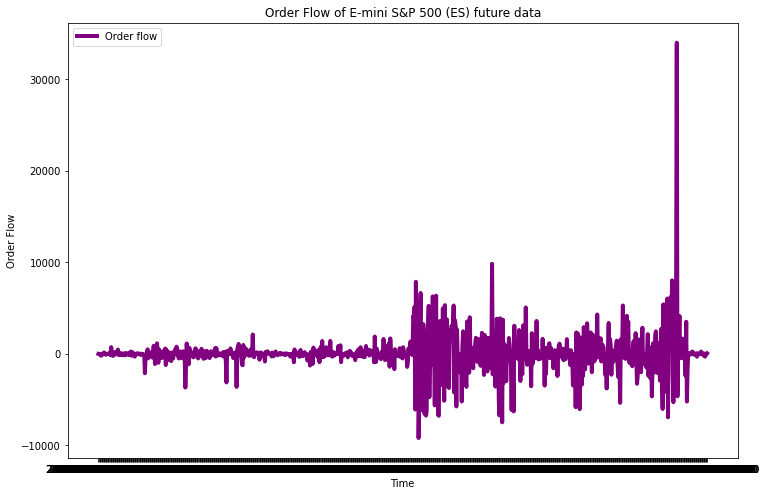

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(compute_order_flow.index, compute_order_flow['buy_ordflow'], label='Buy Order Flow', linewidth=4)
# plt.plot(compute_order_flow.index, compute_order_flow['sell_ordflow'], label='Sell Order Flow', linewidth=2)
plt.plot(orderflow.index, orderflow['net_ordflow'], label='Order flow', linewidth=4, color = 'purple')

ax.legend()
ax.set_title('Order Flow of E-mini S&P 500 (ES) future data')
ax.set_xlabel('Time')
ax.set_ylabel('Order Flow')
plt.show()

# Question 2
Using the aggressor tag of the TAQ data, again compute the order flow per minute by summing the order flow of individual trade ticks with each minute bar. Plot its value over time. Does the last 5 minutes of the order flow based on this method agree with the value computed in Part 1? (4 pt)

In [52]:
TAQ_DATA.head()

,Event,Price,Quantity,Aggressor
Time,,,,
00:00:00.001,T,1988.75,2,S
00:00:00.005,T,1988.75,2,S
00:00:00.005,T,1988.75,1,S
00:00:00.005,T,1988.75,1,S
00:00:00.005,T,1988.75,1,S


In [53]:
TAQ_DATA['Event'].value_counts()
print('\n')
TAQ_DATA['Aggressor'].value_counts()
TAQ_DATA.shape

T    724687
Name: Event, dtype: int64

S    366662
B    358025
Name: Aggressor, dtype: int64

(724687, 4)

In [54]:
# Event=T in the second column indicates this is a trade tick, 
# and the Aggressor=B/S  in the last column indicates whether this is buy or sell. 

# lookback period is the minute
lookback = 100
numRows = TAQ_DATA.shape[0]

# buy_ordflow is the fraction of order flow due to buy orders .
# sell_ordflow is the fraction of order flow due to sell orders.

column_names=['buy_ordflow','sell_ordflow']
# issue with mlfinl lab coz empty df bug is there in the version of pandas which is compatible with mflinlab
orderflow2 = pd.DataFrame(index=range(numRows),columns=column_names)
orderflow2['datetime'] = TAQ_DATA.index


#for t in range(lookback+1,numRows):
for t in range(numRows):

  #deltaPrice = TAQ_DATA.iloc[t,3] - PV_BAR_DATA.iloc[t-1,3]
  #myDeltaPrice = TAQ_DATA.iloc[t-lookback:t-1,3].diff()
  #myDeltaPrice = myDeltaPrice.replace({np.nan: None})
  #orderflow.iloc[t,0]= stats.norm.cdf(deltaPrice, loc = 0, scale = myDeltaPrice.std())
  #orderflow.iloc[t,1] = 1- orderflow.iloc[t,0] 
  if(TAQ_DATA.iloc[t,0]=='T' and TAQ_DATA.iloc[t,3]=='B'):
    orderflow2.iloc[t,0] = +1*TAQ_DATA.iloc[t,2]
  elif(TAQ_DATA.iloc[t,0]=='T' and TAQ_DATA.iloc[t,3]=='S'):
    orderflow2.iloc[t,1] = -1*TAQ_DATA.iloc[t,2] 


In [68]:
orderflow2.head(10)
orderflow2.tail(10)
orderflow2.shape
orderflow2a = orderflow2.copy(deep = "True")
orderflow2a = orderflow2a.fillna(0)



,buy_ordflow,sell_ordflow,datetime
0,NaN,-2,00:00:00.001
1,NaN,-2,00:00:00.005
2,NaN,-1,00:00:00.005
3,NaN,-1,00:00:00.005
4,NaN,-1,00:00:00.005
5,NaN,-1,00:00:00.005
6,NaN,-1,00:00:00.005
7,NaN,-1,00:00:00.005
8,NaN,-1,00:00:00.005
9,NaN,-1,00:00:00.005


,buy_ordflow,sell_ordflow,datetime
724677,NaN,-1,21:14:57.502
724678,1,NaN,21:14:57.663
724679,NaN,-7,21:14:57.828
724680,NaN,-2,21:14:58.220
724681,NaN,-4,21:14:58.512
724682,NaN,-100,21:14:58.781
724683,NaN,-98,21:14:59.141
724684,NaN,-2,21:14:59.141
724685,NaN,-2,21:14:59.142
724686,NaN,-1,21:14:59.142


(724687, 3)

buy_ordflow  sell_ordflow  datetime    
1             0            19:59:33.214    54
0            -1            07:50:37.355    39
1             0            19:59:33.220    36
                           20:06:28.297    36
                           19:59:33.217    36
                                           ..
0            -1            14:25:28.942     1
                           14:25:30.409     1
                           14:25:30.838     1
                           14:25:30.839     1
556           0            09:16:35.210     1
Length: 368645, dtype: int64

In [70]:
# orderflow2a.buy_ordflow.value_counts()

In [56]:
orderflow2a.index = TAQ_DATA.index
orderflow2a.head()
orderflow2a.tail()
TAQ_DATA.index.min()
TAQ_DATA.index.max()

,buy_ordflow,sell_ordflow,datetime
Time,,,
00:00:00.001,0,-2,00:00:00.001
00:00:00.005,0,-2,00:00:00.005
00:00:00.005,0,-1,00:00:00.005
00:00:00.005,0,-1,00:00:00.005
00:00:00.005,0,-1,00:00:00.005


,buy_ordflow,sell_ordflow,datetime
Time,,,
21:14:58.781,0,-100,21:14:58.781
21:14:59.141,0,-98,21:14:59.141
21:14:59.141,0,-2,21:14:59.141
21:14:59.142,0,-2,21:14:59.142
21:14:59.142,0,-1,21:14:59.142


'00:00:00.001'

'21:14:59.142'

In [57]:
# Adding a new column for calculating cummulative sum for each row
# cusum will help us to resample the data per minute
orderflow2a['cumsum_buy_ordflow'] = np.nan
orderflow2a['cumsum_sell_ordflow'] = np.nan

for i in tqdm(orderflow2a.index):
  orderflow2a.loc[i, 'cumsum_buy_ordflow'] = np.cumsum(orderflow2a.loc[i, 'buy_ordflow'])
  orderflow2a.loc[i, 'cumsum_sell_ordflow'] = np.cumsum(orderflow2a.loc[i, 'sell_ordflow'])


orderflow2a.head()
orderflow2a.tail()

100%|██████████| 724687/724687 [11:17<00:00, 1069.57it/s]


,buy_ordflow,sell_ordflow,datetime,cumsum_buy_ordflow,cumsum_sell_ordflow
Time,,,,,
00:00:00.001,0,-2,00:00:00.001,0.0,-2.0
00:00:00.005,0,-2,00:00:00.005,0.0,-2.0
00:00:00.005,0,-1,00:00:00.005,0.0,-3.0
00:00:00.005,0,-1,00:00:00.005,0.0,-4.0
00:00:00.005,0,-1,00:00:00.005,0.0,-5.0


,buy_ordflow,sell_ordflow,datetime,cumsum_buy_ordflow,cumsum_sell_ordflow
Time,,,,,
21:14:58.781,0,-100,21:14:58.781,0.0,-100.0
21:14:59.141,0,-98,21:14:59.141,0.0,-98.0
21:14:59.141,0,-2,21:14:59.141,0.0,-100.0
21:14:59.142,0,-2,21:14:59.142,0.0,-2.0
21:14:59.142,0,-1,21:14:59.142,0.0,-3.0


In [58]:
orderflow2a.index = pd.to_datetime(orderflow2a.index)
orderflow2a.dtypes

buy_ordflow              int64
sell_ordflow             int64
datetime                object
cumsum_buy_ordflow     float64
cumsum_sell_ordflow    float64
dtype: object

In [59]:
orderflow2a.shape
orderflow2b = orderflow2a.copy(deep = "True")
orderflow2b = orderflow2b.resample('1T').last()
orderflow2b.shape


(724687, 5)

(1275, 5)

In [60]:
orderflow2b.head()
orderflow2b.tail()

,buy_ordflow,sell_ordflow,datetime,cumsum_buy_ordflow,cumsum_sell_ordflow
Time,,,,,
2023-03-19 00:00:00,1.0,0.0,00:00:57.215,3.0,0.0
2023-03-19 00:01:00,1.0,0.0,00:01:56.059,10.0,0.0
2023-03-19 00:02:00,0.0,-1.0,00:02:58.155,0.0,-1.0
2023-03-19 00:03:00,2.0,0.0,00:03:53.067,2.0,0.0
2023-03-19 00:04:00,2.0,0.0,00:04:57.512,10.0,0.0


,buy_ordflow,sell_ordflow,datetime,cumsum_buy_ordflow,cumsum_sell_ordflow
Time,,,,,
2023-03-19 21:10:00,2.0,0.0,21:10:55.360,2.0,0.0
2023-03-19 21:11:00,1.0,0.0,21:11:50.737,1.0,0.0
2023-03-19 21:12:00,0.0,-2.0,21:12:58.297,0.0,-39.0
2023-03-19 21:13:00,0.0,-2.0,21:13:57.187,0.0,-2.0
2023-03-19 21:14:00,0.0,-1.0,21:14:59.142,0.0,-3.0


In [61]:

orderflow2b = orderflow2b.fillna(0)
orderflow2b.shape

orderflow2b.head()
orderflow2b.tail()


(1275, 5)

,buy_ordflow,sell_ordflow,datetime,cumsum_buy_ordflow,cumsum_sell_ordflow
Time,,,,,
2023-03-19 00:00:00,1.0,0.0,00:00:57.215,3.0,0.0
2023-03-19 00:01:00,1.0,0.0,00:01:56.059,10.0,0.0
2023-03-19 00:02:00,0.0,-1.0,00:02:58.155,0.0,-1.0
2023-03-19 00:03:00,2.0,0.0,00:03:53.067,2.0,0.0
2023-03-19 00:04:00,2.0,0.0,00:04:57.512,10.0,0.0


,buy_ordflow,sell_ordflow,datetime,cumsum_buy_ordflow,cumsum_sell_ordflow
Time,,,,,
2023-03-19 21:10:00,2.0,0.0,21:10:55.360,2.0,0.0
2023-03-19 21:11:00,1.0,0.0,21:11:50.737,1.0,0.0
2023-03-19 21:12:00,0.0,-2.0,21:12:58.297,0.0,-39.0
2023-03-19 21:13:00,0.0,-2.0,21:13:57.187,0.0,-2.0
2023-03-19 21:14:00,0.0,-1.0,21:14:59.142,0.0,-3.0


In [71]:
# Adding a new column for plotting net order flow
orderflow2b['net_ordflow'] = np.nan
for i in orderflow2b.index:
  orderflow2b.loc[i, 'net_ordflow'] = (orderflow2b.loc[i, 'cumsum_buy_ordflow'] + orderflow2b.loc[i, 'cumsum_sell_ordflow'])


In [72]:
orderflow2b.head()
orderflow2b.tail()

,buy_ordflow,sell_ordflow,datetime,cumsum_buy_ordflow,cumsum_sell_ordflow,net_ordflow
Time,,,,,,
2023-03-19 00:00:00,1.0,0.0,00:00:57.215,3.0,0.0,3.0
2023-03-19 00:01:00,1.0,0.0,00:01:56.059,10.0,0.0,10.0
2023-03-19 00:02:00,0.0,-1.0,00:02:58.155,0.0,-1.0,-1.0
2023-03-19 00:03:00,2.0,0.0,00:03:53.067,2.0,0.0,2.0
2023-03-19 00:04:00,2.0,0.0,00:04:57.512,10.0,0.0,10.0


,buy_ordflow,sell_ordflow,datetime,cumsum_buy_ordflow,cumsum_sell_ordflow,net_ordflow
Time,,,,,,
2023-03-19 21:10:00,2.0,0.0,21:10:55.360,2.0,0.0,2.0
2023-03-19 21:11:00,1.0,0.0,21:11:50.737,1.0,0.0,1.0
2023-03-19 21:12:00,0.0,-2.0,21:12:58.297,0.0,-39.0,-39.0
2023-03-19 21:13:00,0.0,-2.0,21:13:57.187,0.0,-2.0,-2.0
2023-03-19 21:14:00,0.0,-1.0,21:14:59.142,0.0,-3.0,-3.0


Text(0.5, 1.0, 'Order Flow of E-mini S&P 500 (ES) future data')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Order Flow')

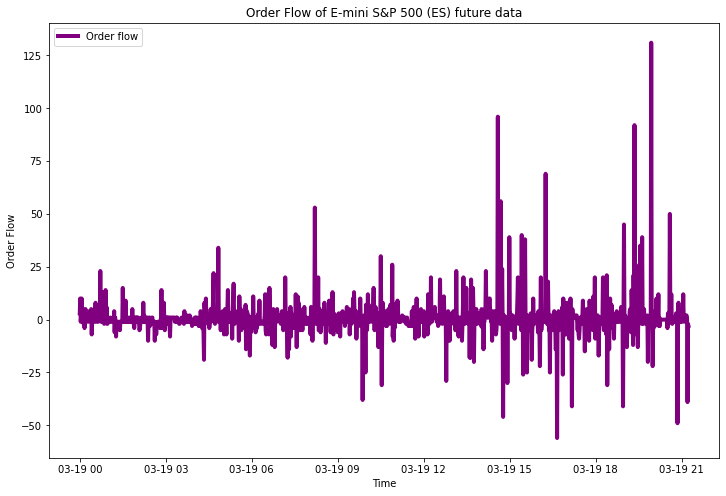

In [73]:
fig, ax = plt.subplots(figsize=(12, 8))
#plt.plot(orderflow2b.index, orderflow2b['cumsum_buy_ordflow'], label='Buy Order Flow', linewidth=4)
#plt.plot(orderflow2b.index, orderflow2b['cumsum_sell_ordflow'], label='Sell Order Flow', linewidth=2)
plt.plot(orderflow2b.index, orderflow2b['net_ordflow'], label='Order flow', linewidth=4, color = 'purple')

ax.legend()
ax.set_title('Order Flow of E-mini S&P 500 (ES) future data')
ax.set_xlabel('Time')
ax.set_ylabel('Order Flow')
plt.show()

# Question 3

If we execute a trading strategy based on whether the order flow of the previous bar is positive or negative, what total P&L would you obtain based on this data? (Note: You can compute P&L based on the price-volume-bar data as an estimate.) (2 pt)

In [65]:
PV_BAR_DATA.head()

,Open,High,Low,Close,Volume
Time,,,,,
2015-08-28 00:00:00,1.943063,1.943308,1.943063,1.943063,49
2015-08-28 00:01:00,1.943063,1.943308,1.943308,1.943308,43
2015-08-28 00:02:00,1.943308,1.943554,1.943308,1.943308,33
2015-08-28 00:03:00,1.943308,1.943308,1.943063,1.943308,100
2015-08-28 00:04:00,1.943308,1.943063,1.942572,1.942572,93


In [66]:
# Function shared by Scott

# Refer Dr.Ernie P Chan, 2017, Machine Trading, Chapter 6.
entryThreshold=0.95;
exitThreshold =0.5;

dailyPL = 0
entryP = 0
pos = 0 

numRows_orderflow = orderflow.shape[0]

for t in range(lookback+1, numRows_orderflow):
    
    if(orderflow.iloc[t,0] > entryThreshold):
        if (pos<=0):
            if(pos < 0):
                # Ask price is the lowest price that someone is willing to sell so we take the Low price in the OHLCV data
                dailyPL += (entryP -  PV_BAR_DATA_updated.iloc[t,2])
                entryP = PV_BAR_DATA_updated.iloc[t,2]
            else :
                entryP = PV_BAR_DATA_updated.iloc[t,2]
            pos = 1 
    
    elif( orderflow.iloc[t,1] > entryThreshold):
        if(pos>=0):
            if (pos > 0):
                dailyPL+= (PV_BAR_DATA_updated.iloc[t,1] - entryP)
                entryP = PV_BAR_DATA_updated.iloc[t,1]
            else :
                entryP = PV_BAR_DATA_updated.iloc[t,1]
            pos = -1
    else:
        if(orderflow.iloc[t,0] <= exitThreshold and pos > 0):
            dailyPL+= (PV_BAR_DATA_updated.iloc[t,1] - entryP)
            pos = 0
        elif(orderflow.iloc[t,1] <= exitThreshold and pos < 0):
            dailyPL+= (entryP - PV_BAR_DATA_updated.iloc[t,2])
            pos = 0

In [67]:
print("The total daily P&L based on the orderflow of price-volume-bar dataset calculated in q#1 is: ",dailyPL)

The total daily P&L based on the orderflow of price-volume-bar dataset calculated in q#1 is:  0.24395661958608073


# Additional Code (Not for assignment responses)

## BVC Function 1

Apply the BVC method to compute the order flow per minute and plot its value over time.

In [126]:
import pandas as pd

def bvc_order_flow_1(df, period=60):
    """
    Calculate the order flow per minute using the BVC method.
    
    Args:
        df (pd.DataFrame): Daily bar data with columns: ['open', 'high', 'low', 'close', 'volume'].
        period (int): The time period in minutes to calculate the order flow.
    
    Returns:
        pd.DataFrame: Order flow per minute.
    """
    # Convert the index to datetime and resample to the desired period
    df.index = pd.to_datetime(df.index)
    df = df.resample(f'{period}min').last()
    
    # Calculate the median price for each period
    median_price = (df['High'] + df['Low']) / 2
    
    # Calculate the daily net order flow
    df['net_order_flow'] = (df['Close'] - df['Open']).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0)) * df['Volume']
    
    # Calculate the BVC order flow for each period
    bvc_order_flow = pd.Series(index=df.index)
    for i in range(1, len(df)):
        prev_median_price = median_price.iloc[i-1]
        curr_median_price = median_price.iloc[i]
        prev_net_order_flow = df['net_order_flow'].iloc[i-1]
        curr_net_order_flow = df['net_order_flow'].iloc[i]
        if curr_median_price > prev_median_price:
            bvc_order_flow.iloc[i] = curr_net_order_flow
        elif curr_median_price < prev_median_price:
            bvc_order_flow.iloc[i] = -curr_net_order_flow
        else:
            bvc_order_flow.iloc[i] = 0
    
    # Resample to 1-minute periods and divide by the period to get the order flow per minute
    bvc_order_flow = bvc_order_flow.resample('1min').ffill() / period
    
    # Calculate the buy and sell order flow
    buy_order_flow = bvc_order_flow.apply(lambda x: x if x > 0 else 0)
    sell_order_flow = bvc_order_flow.apply(lambda x: -x if x < 0 else 0)
    
    # Create a DataFrame with the order flow per minute, buy order flow, and sell order flow
    order_flow = pd.DataFrame({'order_flow': bvc_order_flow, 'buy_order_flow': buy_order_flow, 'sell_order_flow': sell_order_flow})
    
    return order_flow


## BVC Function 2

In [200]:
import pandas as pd
import numpy as np

def compute_order_flow(data):
    # Compute tick direction
    data['tick_direction'] = np.where(data['Close'] > data['Close'].shift(1), 1, -1)
    data['tick_direction'][0] = 0

    # Compute tick volume
    data['tick_volume'] = data['Volume'] * data['tick_direction']

    # Compute minute volume
    data['minute'] = data.index.floor('T')
    minute_volume = data.groupby('minute')['tick_volume'].sum()

    # Compute minute buy and sell volume
    data['buy_volume'] = np.where(data['tick_direction'] == 1, data['tick_volume'], 0)
    data['sell_volume'] = np.where(data['tick_direction'] == -1, data['tick_volume'], 0)
    minute_buy_volume = data.groupby('minute')['buy_volume'].sum()
    minute_sell_volume = data.groupby('minute')['sell_volume'].sum()
    net_order_flow = (minute_buy_volume -minute_sell_volume )
    #net_order_flow= (data['Close'] - data['Open']).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0)) * data['Volume']


    # Compute minute order flow
    minute_order_flow = minute_buy_volume - minute_sell_volume

    # Compute order flow per minute
    minute_order_flow_per_volume = minute_order_flow / minute_volume
    minute_order_flow_per_minute = minute_order_flow_per_volume.resample('1T').last()

    # Combine buy and sell order flow into a single dataframe
    order_flow = pd.DataFrame({'buy_order_flow': minute_buy_volume, 'sell_order_flow': minute_sell_volume, 
                               'order_flow_per_minute': minute_order_flow_per_minute,
                               'net_order_flow':net_order_flow })
    order_flow.index.name = 'minute'

    return order_flow


In [201]:
PV_BAR_DATA_F2 = pd.read_csv(w9_files+"/ES_continuous_20150828.csv")
PV_BAR_DATA_F2['Time'] = pd.to_datetime(PV_BAR_DATA_F2['Time'])

PV_BAR_DATA_F2.head(2)
PV_BAR_DATA_F2.set_index('Time', inplace=True)

PV_BAR_DATA_F2.dtypes

,Time,Open,High,Low,Close,Volume
0,2015-08-28 00:00:00,1.943063,1.943308,1.943063,1.943063,49
1,2015-08-28 00:01:00,1.943063,1.943308,1.943308,1.943308,43


Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [202]:
PV_BAR_DATA_F2 = PV_BAR_DATA_F2.sort_values('Time')

# Calculate the order flow per minute using the BVC method
compute_order_flow = compute_order_flow(PV_BAR_DATA_F2)
#print(order_flow)
compute_order_flow.head()


<ipython-input-200-3d96366511fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tick_direction'][0] = 0


,buy_order_flow,sell_order_flow,order_flow_per_minute,net_order_flow
minute,,,,
2015-08-28 00:00:00,0.0,0.0,NaN,0.0
2015-08-28 00:01:00,43.0,0.0,1.0,43.0
2015-08-28 00:02:00,0.0,-33.0,-1.0,33.0
2015-08-28 00:03:00,0.0,-100.0,-1.0,100.0
2015-08-28 00:04:00,0.0,-93.0,-1.0,93.0


In [203]:
print("\n\n Missing Values before dropping/Imputing \n",compute_order_flow.isna().sum())
compute_order_flow.dropna(inplace = True)
print("\n\n Missing Values after dropping/Imputing \n",compute_order_flow.isna().sum())
print(compute_order_flow.shape)



 Missing Values before dropping/Imputing 
 buy_order_flow           15
sell_order_flow          15
order_flow_per_minute    16
net_order_flow           15
dtype: int64


 Missing Values after dropping/Imputing 
 buy_order_flow           0
sell_order_flow          0
order_flow_per_minute    0
net_order_flow           0
dtype: int64
(1004, 4)


In [204]:
compute_order_flow.tail()
compute_order_flow['order_flow_per_minute'].value_counts()
#compute_order_flow['buy_order_flow'].value_counts()

,buy_order_flow,sell_order_flow,order_flow_per_minute,net_order_flow
minute,,,,
2015-08-28 16:55:00,0.0,-363.0,-1.0,363.0
2015-08-28 16:56:00,0.0,-556.0,-1.0,556.0
2015-08-28 16:57:00,0.0,-539.0,-1.0,539.0
2015-08-28 16:58:00,0.0,-191.0,-1.0,191.0
2015-08-28 16:59:00,313.0,0.0,1.0,313.0


-1.0    566
 1.0    438
Name: order_flow_per_minute, dtype: int64

Text(0.5, 1.0, 'Order Flow')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Order Flow')

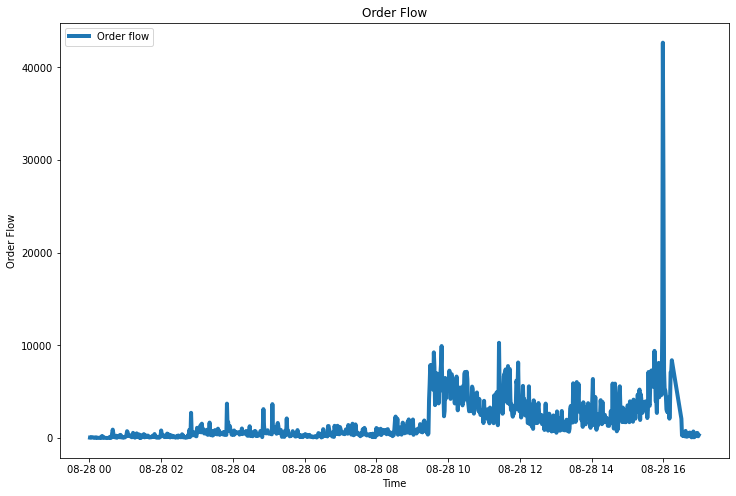

In [205]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(compute_order_flow.index, compute_order_flow['buy_order_flow'], label='Buy Order Flow', linewidth=4)
# plt.plot(compute_order_flow.index, compute_order_flow['sell_order_flow'], label='Sell Order Flow', linewidth=2)
plt.plot(compute_order_flow.index, compute_order_flow['net_order_flow'], label='Order flow', linewidth=4)

ax.legend()
ax.set_title('Order Flow')
ax.set_xlabel('Time')
ax.set_ylabel('Order Flow')
plt.show()

In [157]:
compute_order_flow.tail()

,buy_order_flow,sell_order_flow,order_flow_per_minute,net_order_flow
minute,,,,
2015-08-28 16:55:00,0.0,-363.0,-1.0,-363.0
2015-08-28 16:56:00,0.0,-556.0,-1.0,-556.0
2015-08-28 16:57:00,0.0,-539.0,-1.0,0.0
2015-08-28 16:58:00,0.0,-191.0,-1.0,-191.0
2015-08-28 16:59:00,313.0,0.0,1.0,313.0


## BVC Function 1

In [78]:
def bvc_order_flow(df, period=60):
    """
    Calculate the order flow per minute using the BVC method.
    
    Args:
        df (pd.DataFrame): Daily bar data with columns: ['open', 'high', 'low', 'close', 'volume'].
        period (int): The time period in minutes to calculate the order flow.
    
    Returns:
        pd.DataFrame: Order flow per minute.
    """
    # Convert the index to datetime and resample to the desired period
    df.index = pd.to_datetime(df.index)
    df = df.resample(f'{period}min').last()
    
    # Calculate the median price for each period
    median_price = (df['High'] + df['Low']) / 2
    
    # Calculate the daily net order flow
    df['net_order_flow'] = (df['Close'] - df['Open']).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0)) * df['Volume']
    
    # Calculate the BVC order flow for each period
    bvc_order_flow = pd.Series(index=df.index)
    for i in range(1, len(df)):
        prev_median_price = median_price.iloc[i-1]
        curr_median_price = median_price.iloc[i]
        prev_net_order_flow = df['net_order_flow'].iloc[i-1]
        curr_net_order_flow = df['net_order_flow'].iloc[i]
        if curr_median_price > prev_median_price:
            bvc_order_flow.iloc[i] = curr_net_order_flow
        elif curr_median_price < prev_median_price:
            bvc_order_flow.iloc[i] = -curr_net_order_flow
        else:
            bvc_order_flow.iloc[i] = 0
    
    # Resample to 1-minute periods and divide by the period to get the order flow per minute
    bvc_order_flow = bvc_order_flow.resample('1min').ffill() / period
    order_flow = pd.DataFrame({'order_flow': bvc_order_flow})

    
    return order_flow


## 1a Without buy and Sell OF calculation

In [81]:

# Calculate the order flow per minute using the BVC method
order_flow1 = bvc_order_flow(PV_BAR_DATA, period=60)
order_flow1.head()
order_flow1.shape


<ipython-input-78-0d93be3a12bf>:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  bvc_order_flow = pd.Series(index=df.index)


,order_flow
Time,
2015-08-28 00:00:00,NaN
2015-08-28 00:01:00,NaN
2015-08-28 00:02:00,NaN
2015-08-28 00:03:00,NaN
2015-08-28 00:04:00,NaN


(961, 1)

In [82]:
order_flow1.dropna(inplace = True)
print("\n\n Missing Values before dropping/Imputing \n",order_flow1.isna().sum())
print(order_flow1.shape)
PV_BAR_OF1 = PV_BAR_DATA.copy()
PV_BAR_OF1 = PV_BAR_DATA[PV_BAR_DATA.index.isin(order_flow1.index)]
PV_BAR_OF1.head()
PV_BAR_OF1.shape




 Missing Values before dropping/Imputing 
 order_flow    0
dtype: int64
(901, 1)


,Open,High,Low,Close,Volume
Time,,,,,
2015-08-28 01:00:00,1.945763,1.946254,1.945763,1.946254,134
2015-08-28 01:01:00,1.946254,1.946499,1.945517,1.945517,159
2015-08-28 01:02:00,1.945517,1.946744,1.945272,1.946499,353
2015-08-28 01:03:00,1.946499,1.946499,1.944045,1.944290,742
2015-08-28 01:04:00,1.944290,1.944045,1.943308,1.943308,613


(901, 5)

In [83]:
order_flow1['order_flow'].value_counts()

 4.133333      60
-3.216667      60
-10.766667     60
-9.716667      60
 3.800000      60
 19.816667     60
-5.000000      60
-18.233333     60
 85.416667     60
 27.000000     60
 48.500000     60
 33.866667     60
 39.966667     60
-39.883333     60
 710.816667    60
 5.216667       1
Name: order_flow, dtype: int64